#### This is the pipeline on the single_datasets, executed in docker container

`docker pull tensorflow/tensorflow:latest-gpu-jupyter`

`docker run --gpus all -it -v /work/acdc-research-project-ss24/shengyao:/tf -p 8888:8888 --rm tensorflow/tensorflow:latest-gpu-jupyter`

#### Import dependencies

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import random
import glob
import re
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate

from segmentation_utils.metrics import SparseMeanIoU
from mpl_toolkits.axes_grid1 import ImageGrid
from segmentation_utils.image_segmentation_utils import *
random.seed(123)


%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')

print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

#### Get the file paths of train dataset

In [4]:
# get train pathes

folder_path='/tf/single_datasets'
images_path_train=[]
labels_path_train=[]
pattern='.*?/train_x'

for foldername, subfolders, filenames in os.walk(folder_path):
    if re.match(pattern,foldername)!=None:
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            images_path_train.append(file_path)
images_path_train=sorted(images_path_train)

pattern='.*?/train_y'
for foldername, subfolders, filenames in os.walk(folder_path):
    if re.match(pattern,foldername)!=None:
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            labels_path_train.append(file_path)
labels_path_train=sorted(labels_path_train)
# shuffle the dataset
fused_list = list(zip(images_path_train, labels_path_train))
random.shuffle(fused_list)
images_path_train, labels_path_train = map(list, zip(*fused_list))

print(images_path_train[0])
print(labels_path_train[0])


/tf/single_datasets/4_Town07_0.2_50_ClearSunset/train_x/image_0342.png
/tf/single_datasets/4_Town07_0.2_50_ClearSunset/train_y/image_0342.png


#### Get the file paths of validation dataset

In [5]:
## get validation pathes

folder_path='/tf/single_datasets'
images_path_val=[]
labels_path_val=[]
pattern='.*?/test_x'

for foldername, subfolders, filenames in os.walk(folder_path):
    if re.match(pattern,foldername)!=None:
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            images_path_val.append(file_path)
images_path_val=sorted(images_path_val)

pattern='.*?/test_y'
for foldername, subfolders, filenames in os.walk(folder_path):
    if re.match(pattern,foldername)!=None:
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            labels_path_val.append(file_path)
labels_path_val=sorted(labels_path_val)
# shuffle the dataset
fused_list = list(zip(images_path_val, labels_path_val))
random.shuffle(fused_list)
images_path_val, labels_path_val = map(list, zip(*fused_list))

print(images_path_val[0])
print(labels_path_val[0])


/tf/single_datasets/7_Town07_0.2_50_ClearSunset/test_x/image_0326.png
/tf/single_datasets/7_Town07_0.2_50_ClearSunset/test_y/image_0326.png


#### Pipeline and augumentation

In [6]:
rgb_to_class_id = {
    (128, 64, 128):  0,   # Road
    (244, 35, 232):  1,   # Sidewalk
    (250, 170, 160): 2,   # Parking
    (230, 150, 140): 3,   # Tail track
    (220,  20,  60): 4,   # Person
    (255,   0,   0): 5,   # Rider
    (  0,   0, 142): 6,   # Car
    (  0,   0,  70): 7,   # Truck
    (  0,  60, 100): 8,   # Bus
    (  0,  80, 100): 9,   # On Rails
    (  0,   0, 230): 10,  # Motorcycle
    (119,  11,  32): 11,  # Bicycle
    (  0,   0,  90): 12,  # Caravan
    (  0,   0, 110): 13,  # Trailer
    ( 70,  70,  70): 14,  # Building
    (102, 102, 156): 15,  # Wall
    (190, 153, 153): 16,  # Fence
    (180, 165, 180): 17,  # Guard Rail
    (150, 100, 100): 18,  # Bridge
    ( 50, 120,  90): 19,  # Tunnel
    (153, 153, 153): 20,  # Pole
    (220, 220,   0): 21,  # Traffic sign
    (250, 170,  30): 22,  # Traffic light
    (107, 142,  35): 23,  # Vegetation
    (152, 251, 152): 24,  # Terrain
    ( 70, 130, 180): 25,  # Sky
    ( 81,   0,  81): 26,  # Ground
    (111,  74,   0): 27,  # Dynamic
    ( 20,  20,  20): 28,  # Static
    (  0,   0,   0): 29   # None
}

In [7]:
def convert_rgb_encoding_to_segmentation_map(image, rgb_to_class_id):
    """
    Converts an image with the RGB class encoding into a class map.
    
    Argument:
    image -- tf.tensor of shape [heigh, width, 3] which contains for each pixel a tuple of (R, G, B) values.
    
    Returns:
    class_map -- tf.tensor of shape [heigh, width, 1] which contains for each pixel a single integer that represents a class
    """

    segmentation_map = tf.zeros([image.shape[0], image.shape[1]], dtype=tf.uint8)

    for color, class_id in rgb_to_class_id.items():    
    ### START CODE HERE ###
    
        segmentation_map = tf.where(
                                    condition=tf.reduce_all(tf.equal(image, color), axis=-1), # condition=None,
                                    x=tf.cast(class_id, tf.uint8),                            # x=None,
                                    y=segmentation_map                                        # y=None
                                    )
        
    # Add dimension to change the shape from [height, width] to [height, width, 1]
    segmentation_map = tf.expand_dims(segmentation_map, -1)  # segmentation_map = None
    ### END CODE HERE ###
        
    return segmentation_map

In [8]:
def parse_sample(image_path, label_path):
    """
    Argument:
    image_path -- String which contains the path to the camera image
    label_path -- String which contains the path to the label image
    
    Returns:
    image_rgb -- tf.Tensor of size [368, 1248, 3] containing the camera image
    label_segmentation_map -- tf.Tensor of size [368, 1248, 1] containing the segmentation map
    """
    ### START CODE HERE ### 
    image_rgb = tf.image.decode_png(tf.io.read_file(image_path), channels=3) 
    label_rgb = tf.image.decode_png(tf.io.read_file(label_path), channels=3)  
    
    image_rgb = tf.image.resize(image_rgb, [512, 1024], method=tf.image.ResizeMethod.BILINEAR)  #can't be deleted, otherwise there would be Nonetype error
    label_rgb = tf.image.resize(label_rgb, [512, 1024], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  #
    # resize returns tf.float32 for BILINEAR, convert back to tf.uint8
    image_rgb = tf.cast(image_rgb, tf.uint8) 
    
    # apply convert_rgb_encoding_to_segmentation_map to the label_rgb image
    label_segmentation_map = convert_rgb_encoding_to_segmentation_map(label_rgb, rgb_to_class_id)  
    ### END CODE HERE ###
    
    return image_rgb, label_segmentation_map

In [9]:
def random_flip(image, label):
    """
    Randomly flips the image-label pair along the 1-dimension with probability 0.5.
    
    Arguments:
    image -- tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    
    Returns:
    image -- Augmented tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- Augmented tf.Tensor with shape [width, height] representing the corresponding segmentation map
    """
    # creates a random float between 0 and 1
    random = tf.random.uniform(shape=[], minval=0, maxval=1, dtype=tf.float16)
    
    ### START CODE HERE ###
    (image, label) = tf.cond(
                             pred=random > 0.5,   # pred=None,
                             true_fn=lambda: (tf.image.flip_left_right(image), tf.image.flip_left_right(label)),   # true_fn=lambda: (None, None),
                             false_fn=lambda: (image, label)  # false_fn=lambda: (None, None)
                             )
    ### END CODE HERE ###
    return image, label

In [10]:
def random_gamma(image, label):
    """
    Randomly applies gamma augmentation to the image. The label should not be changed.
    
    Arguments:
    image -- tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    
    Returns:
    image -- Augmented tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    """
    ### START CODE HERE ###
    random_gamma = tf.random.uniform(shape=[], minval=0.3, maxval=1.2, dtype=tf.float32)  # random_gamma = None
    image = tf.image.adjust_gamma(image, gamma=random_gamma)  # image = None
    ### END CODE HERE ###
    return image, label 

In [11]:
def random_brightness(image, label):
    """
    Randomly applies brightness augmentation to the image. The label should not be changed.
    
    Arguments:
    image -- tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    
    Returns:
    image -- Augmented tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    """
    ### START CODE HERE ###
    image = tf.image.random_brightness(image, 0.4)  # image = None
    ### END CODE HERE ###
    return image, label

In [12]:
def random_contrast(image, label):
    """
    Randomly applies contrast augmentation to the image. The label should not be changed.
    
    Arguments:
    image -- tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    
    Returns:
    image -- Augmented tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    """
    ### START CODE HERE ###
    image = tf.image.random_contrast(image, 0.2, 1.1) # image = None
    ### END CODE HERE ###
    return image, label

In [13]:
def random_noise(image, label):
    """
    Randomly applies contrast augmentation to the image. The label should not be changed.
    
    Arguments:
    image -- tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    
    Returns:
    image -- Augmented tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    """
    
    # Create a random standart deviation - simulates the intensity of the noise
    random_stddev = tf.random.uniform(shape=[], minval=2, maxval=30, dtype=tf.float32)
    
    ### START CODE HERE ###
    # Create a noise tensor with a shape like the input image. Use zero-mean and a random std
    noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=random_stddev, dtype=tf.float32)  # noise = tf.random.normal(None, mean=None, stddev=None, dtype=None)
    
    # Add the noise to the image. Cast the image to tf.float32 before the addition
    image = tf.cast(image, dtype=tf.float32) + noise  # image = None + None
    
    # Clip the values of the image to [0, 255] 
    image = tf.clip_by_value(image, 0.0, 255.0)  # image = None
    
    # Cast the image back to tf.uint8
    image = tf.cast(image, dtype=tf.uint8)  # image = None
    ### END CODE HERE ###
    
    return image, label

In [14]:
def random_zoom(image, label):
    """
    Randomly applies random zoom augmentation to the image-label pair. Randomly resizes the image 
    and then crops it back to original size.
    
    Arguments:
    image -- tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    
    Returns:
    image -- Augmented tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- Augmented tf.Tensor with shape [width, height] representing the corresponding segmentation map
    """
    # Store the original height, width of the input image
    original_shape = tf.shape(image)[:2]
    
    # Create a random scale between 1 und 2.5
    scale = tf.random.uniform(shape=[], minval=1, maxval=2.5, dtype=tf.float32)
    
    # Calculate the new dimension after scaling the the original image with scale
    new_dim = tf.cast(tf.cast([image.shape[0], image.shape[1]], tf.float32)*scale, tf.int32)
    
    # Resize the image to the new dimension  
    image = tf.image.resize(image, new_dim, method=tf.image.ResizeMethod.BILINEAR)
    label = tf.image.resize(label, new_dim, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # Resize returns tf.float32 for BILINEAR, convert back to tf.uint8
    image = tf.cast(image, tf.uint8)  
    
    # Calculate the positions boundaries of the top left corner of the new crop
    min_top_left = tf.constant([0, 0], dtype=tf.int32)
    max_top_left = new_dim - original_shape
    
    # Generate a random position of the new crop
    x_top_left, y_top_left = min_top_left[1], min_top_left[0]
    if min_top_left[1] < max_top_left[1]:
        x_top_left = tf.random.uniform(shape=[], minval=min_top_left[1], maxval=max_top_left[1], dtype=tf.int32)
    if min_top_left[0] < max_top_left[0]:
        y_top_left = tf.random.uniform(shape=[], minval=min_top_left[0], maxval=max_top_left[0], dtype=tf.int32)
    
    ### START CODE HERE ###
    # Crop the original image using the original shape and the new random position
    image = tf.image.crop_to_bounding_box(
        image=image,                      # image=None,
        offset_height=y_top_left,         # offset_height=None,
        offset_width=x_top_left,          # offset_width=None,
        target_height=original_shape[0],  # target_height=None,
        target_width=original_shape[1]    # target_width=None
    )
    # Crop the original label using the original shape and the new random position
    label = tf.image.crop_to_bounding_box(
        image=label,                       # image=None,
        offset_height=y_top_left,          # offset_height=None,
        offset_width=x_top_left,           # offset_width=None,
        target_height=original_shape[0],   # target_height=None,
        target_width=original_shape[1]     # target_width=None
    )
    ### END CODE HERE ###
    
    return image, label

In [15]:
AUGMENTATION_POLICY = {
    "subpolicy0": [(random_contrast, 0.75),   (random_zoom, 0.75)],
    "subpolicy1": [(random_gamma, 0.75),      (random_zoom, 0.75)],
    "subpolicy2": [(random_noise, 0.75),      (random_zoom, 0.75)],
    "subpolicy3": [(random_brightness, 0.75), (random_zoom, 0.75)],
    "subpolicy4": [(random_gamma, 0.75),      (random_zoom, 0.00)],
    "subpolicy5": [(random_brightness, 0.75), (random_zoom, 0.00)],
}

In [16]:
def apply_augmentation_subpolicy(image, label, subpolicy):
    """
    Applies a subpolicy to an input image and label. Return the augmented image and label.
    
    Arguments:
    - image -- tf.Tensor with shape [height, width, 3] representing the camera image 
    - label -- tf.Tensor with shape [height, width] representing the label
    - subpolicy -- List that contains several tuples of (augmentation_fuc, probability)
                  where probability is in [0, 1]. Each tuple is called operation. The probability 
                  determines the probability to apply the operation.
    
    Returns:
    - image -- Augmented tf.Tensor with shape [height, width, 3] representing the camera image
    - label -- Augmented tf.Tensor with shape [height, width] representing the label
    """
    
    for operation in subpolicy:
        ### START CODE HERE ###
        
        # get the augmentation function from operation, remember that the function is the first element of an operation
        func = operation[0]  # func = None
        
        # get the probability from operation, remember that the probability is the second element of an operation
        prob = operation[1]  # prob = None

        # pull a random float from a uniform distribution from [0, 1]
        random_float = tf.random.uniform([], 0, 1)  # random_float = None
        
        # apply func to (image, label) only when random_float <= prob 
        image, label = tf.cond(
            pred=random_float <= prob,              # pred = None,
            true_fn=lambda: func(image, label),     # true_fn=lambda: None, 
            false_fn=lambda: (image, label)         # false_fn=lambda: None 
            )
        
        ### END CODE HERE ###
    return image, label

In [17]:
def apply_augmentation_policy(image, label, policy):
    """
    Applies a policy to a input image and label. Returns the augmented image and label.
    
    Arguments:
    - image -- tf.Tensor with shape [height, width, 3] representing the camera image
    - label -- tf.Tensor with shape [height, width] representing the label
    - policy -- Dictionary which contains subpolicies. Each element in the dictionary has
                the key `subpolicyX` where X represents the index starting from 0.
    
    Returns:
    - image -- Augmented tf.Tensor with shape [height, width, 3] representing the camera image
    - label -- Augmented tf.Tensor with shape [height, width] representing the label
    """
    ### START CODE HERE ###
    
    # always radnom flip the image before any other augmentation
    image, label = random_flip(image, label)  # image, label = None
    
    # get the number of subpolicies
    num_policies = len(policy)  # num_policies = None
    
    # create a random integer in [0, num_policies)
    random_policy = tf.random.uniform(shape=[], minval=0, maxval=num_policies, dtype=tf.int32)  # random_policy = None

    # take all policies and choose random policy based on idx
    for idx in range(num_policies):
        image, label = tf.cond(
                    pred=tf.equal(random_policy, idx),   # pred=None,
                    true_fn=lambda: apply_augmentation_subpolicy(image, label, policy["subpolicy"+str(idx)]),   #  true_fn=lambda: apply_augmentation_subpolicy(None, None, None),
                    false_fn=lambda: (image, label)      # false_fn=lambda: None
                    )
    ### END CODE HERE ###
    
    return image, label

In [18]:
def augmentation_wrapper(image, label):
    image, label = apply_augmentation_policy(image, label, AUGMENTATION_POLICY) 
    return image, label

In [19]:
def normalize(image, label):
    """
    Normalizes the input image from range [0, 255] to [0, 1.0]
    Arguments:
    image -- tf.tensor representing a RGB image with integer values in range [0, 255] 
    label -- tf.tensor representing the corresponding segmentation mask
    
    Returns:
    image -- tf.tensor representing a RGB image with integer values in range [0, 1] 
    label -- tf.tensor representing the corresponding segmentation mask
    """
    image = tf.cast(image, tf.float32) / 255.0  
    
    return image, label

In [20]:
def create_dataset(images_path, labels_path, batch_size=4, buffer_size=200, do_augmentation=False):
    """
    Dataset creation function. Creates a input pipeline for semantic image segmentation.
    
    Arguments:
    - images_path -- List of Strings which contain pathes for the camera images
    - labels_path -- List of Strings which contain pathes for the label images
    - batch_size -- Integer - Size of the batches during data creation
    - buffer_size -- Integer - Size of the buffer for shuffeling
    - do_augmentation -- Boolean - If True, apply data augmentation
    
    Returns:
    - dataset -- tf.data.Dataset
    """
    
    dataset = tf.data.Dataset.from_tensor_slices((images_path, labels_path))
    # Shuffle the dataset with buffer_size
    dataset = dataset.shuffle(buffer_size=buffer_size)
    # Apply the parse_sample function. Use tf.data.AUTOTUNE for the number of parallel calls
    dataset = dataset.map(parse_sample, num_parallel_calls=tf.data.AUTOTUNE)
    
    ### START CODE HERE ### 
    # Apply augmentation policy
    if do_augmentation:  # if None:
        dataset = dataset.map(augmentation_wrapper, num_parallel_calls=tf.data.AUTOTUNE)   # dataset = None
    ### END CODE HERE ###
    
    dataset = dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
    # Apply batching to the dataset using batch_size
    dataset = dataset.batch(batch_size=batch_size)
    # Use prefetching 
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

#### Create the datasets

In [21]:
train = create_dataset(images_path_train, labels_path_train, batch_size=8, do_augmentation=True)
# Create the validation dataset
val = create_dataset(images_path_val, labels_path_val, batch_size=8, do_augmentation=False)   # val = None

In [22]:
print("Train Dataset Length:", tf.data.experimental.cardinality(train).numpy())
print("Val Dataset Length:", tf.data.experimental.cardinality(val).numpy())

Train Dataset Length: 306
Val Dataset Length: 124


#### Build the model 

In [23]:
def encoder(input,
            udepth,
            filters1,
            kernel_size,
            activation,
            batch_norm,
            dropout):

    t = input
    encoder_layers = udepth * [None]

    # layer creation with successive pooling
    for d in range(udepth):
        filters = (2**d) * filters1
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation)(t)
        t = BatchNormalization()(t) if batch_norm else t
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation)(t)
        t = encoder_layers[d] = BatchNormalization()(t) if batch_norm else t
        if d < (udepth - 1):
            t = MaxPooling2D(pool_size=(2, 2), padding="same")(t)
            t = Dropout(rate=dropout)(t) if dropout > 0 else t

    return encoder_layers


def decoder(encoder_layers,
            udepth,
            filters1,
            kernel_size,
            activation,
            batch_norm,
            dropout):

    # start at lowest encoder layer
    t = encoder_layers[udepth - 1]

    # layer expansion symmetric to encoder
    for d in reversed(range(udepth - 1)):
        filters = (2**d) * filters1
        t = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=(2, 2),
                            padding="same")(t)

        t = Concatenate()([encoder_layers[d], t])
        t = Dropout(rate=dropout)(t) if dropout > 0 else t
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation)(t)
        t = BatchNormalization()(t) if batch_norm else t
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation)(t)
        t = BatchNormalization()(t) if batch_norm else t

    return t

In [24]:
def getModel(input_shape,
             num_classes,
             udepth=5,
             filters1=16,
             kernel_size=(3, 3),
             activation=tf.nn.relu,
             batch_norm=True,
             dropout=0.1):
    """
    This function assembles the U-Net architecture and returns a Keras model which can be trained, saved and loaded.
    
    Arguments:
    input_shape -- Input shape of the model as tuple or list
    num_classes -- Number of classes to predict as int
    udepth -- Depth of the network
    filters1 -- Number of filters at the first layer
    kernel_size -- Kernel size for the convolutional operations
    activation -- Type of the Activation function
    batch_norm -- Boolean if batch norm should be applied
    dropout -- Dropout regularization  
    
    Returns:
    segmentation_model -- Keras Model
    """
    
    ### START CODE HERE ### 
    
    # create input layer
    input_tensor = Input(input_shape)  # input_tensor = None

    # construct encoder
    encoder_layers = encoder(input=input_tensor,     # input=None,
                             udepth=udepth,          # udepth=None,
                             filters1=filters1,      # filters1=None,
                             kernel_size=kernel_size,# kernel_size=None,
                             activation=activation,  # activation=None,
                             batch_norm=batch_norm,  # batch_norm=None,
                             dropout=dropout         # dropout=None
                            )

    # construct decoder
    reconstruction = decoder(encoder_layers=encoder_layers, # encoder_layers=None,
                             udepth=udepth,                 # udepth=None,
                             filters1=filters1,             # filters1=None,
                             kernel_size=kernel_size,       # kernel_size=None,
                             activation=activation,         # activation=None,
                             batch_norm=batch_norm,         # batch_norm=None,
                             dropout=dropout                # dropout=None
                            )

    # build final prediction layer
    logits = Conv2D(filters=num_classes,                    # filters=None
                    kernel_size=kernel_size,
                    padding="same",
                    activation=activation)(reconstruction)  # activation=activation)(None)
    
    # apply softmax activation function to the logits 
    probabilities = Activation("softmax")(logits)           # probabilities = None
    
    # create a Keras model
    segmentation_model = Model(inputs=input_tensor, outputs=probabilities)   # segmentation_model = Model(inputs=None, outputs=None)
    
    ### END CODE HERE ###
    
    return segmentation_model

In [25]:
model = getModel(input_shape=[512, 1024, 3], num_classes=30)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 1024, │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 1024, │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 1024, │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 1024, │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 1024, │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 512,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 512,  │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 512,  │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 512,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 512,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 512,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 256,  │          0 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 256,  │     18,496 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │        256 │ conv2d_5[0][0]  

 Total params: 2,168,926 (8.27 MB)

 Trainable params: 2,165,982 (8.26 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=[SparseMeanIoU(num_classes=30, name="MIoU")])

#### Check the local GPU device 

In [27]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [28]:

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')

print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Make tensorflow train on GPU

In [101]:
#tf.config.experimental.set_visible_devices(devices=gpus, device_type='GPU')

#### Train model on local machine.

In [29]:
history = model.fit(train, validation_data=val, epochs=100)

Epoch 1/100


I0000 00:00:1719563926.268522     462 service.cc:145] XLA service 0x7f9aa40411b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719563926.268597     462 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
W0000 00:00:1719563927.425259     462 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1719563927.425311     462 assert_op.cc:38] Ignoring Assert operator Assert/Assert


  1/612 ━━━━━━━━━━━━━━━━━━━━ 5:19:49 31s/step - MIoU: 0.0043 - loss: 3.5680

I0000 00:00:1719563949.956344     462 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


612/612 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - MIoU: 0.0406 - loss: 1.2589

W0000 00:00:1719564057.415837     465 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1719564057.415908     465 assert_op.cc:38] Ignoring Assert operator Assert/Assert
W0000 00:00:1719564071.737170     463 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1719564071.737190     463 assert_op.cc:38] Ignoring Assert operator Assert/Assert


612/612 ━━━━━━━━━━━━━━━━━━━━ 156s 204ms/step - MIoU: 0.0406 - loss: 1.2583 - val_MIoU: 0.0942 - val_loss: 2.1466
Epoch 2/100
612/612 ━━━━━━━━━━━━━━━━━━━━ 125s 203ms/step - MIoU: 0.0831 - loss: 0.6295 - val_MIoU: 0.1472 - val_loss: 0.5171
Epoch 3/100
612/612 ━━━━━━━━━━━━━━━━━━━━ 125s 203ms/step - MIoU: 0.1205 - loss: 0.5270 - val_MIoU: 0.1924 - val_loss: 0.5563
Epoch 4/100
612/612 ━━━━━━━━━━━━━━━━━━━━ 126s 205ms/step - MIoU: 0.1167 - loss: 0.4835 - val_MIoU: 0.2002 - val_loss: 0.5229
Epoch 5/100
612/612 ━━━━━━━━━━━━━━━━━━━━ 127s 206ms/step - MIoU: 0.1586 - loss: 0.4134 - val_MIoU: 0.3263 - val_loss: 0.2621
Epoch 6/100
612/612 ━━━━━━━━━━━━━━━━━━━━ 128s 208ms/step - MIoU: 0.1603 - loss: 0.3652 - val_MIoU: 0.3199 - val_loss: 0.2895
Epoch 7/100
612/612 ━━━━━━━━━━━━━━━━━━━━ 133s 216ms/step - MIoU: 0.1787 - loss: 0.3554 - val_MIoU: 0.3808 - val_loss: 0.2176
Epoch 8/100
612/612 ━━━━━━━━━━━━━━━━━━━━ 129s 209ms/step - MIoU: 0.1959 - loss: 0.3246 - val_MIoU: 0.3447 - val_loss: 0.2871
Epoch 9/100


In [29]:
history = model.fit(train, validation_data=val, epochs=200)

Epoch 1/200


I0000 00:00:1719577850.431058   14068 service.cc:145] XLA service 0x7f6a4c0402d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719577850.431133   14068 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
W0000 00:00:1719577851.685139   14068 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1719577851.685226   14068 assert_op.cc:38] Ignoring Assert operator Assert/Assert
I0000 00:00:1719577882.735112   14068 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - MIoU: 0.0398 - loss: 1.3800

W0000 00:00:1719577990.218634   14067 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1719577990.221292   14067 assert_op.cc:38] Ignoring Assert operator Assert/Assert
W0000 00:00:1719578004.542817   14067 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1719578004.542838   14067 assert_op.cc:38] Ignoring Assert operator Assert/Assert


306/306 ━━━━━━━━━━━━━━━━━━━━ 168s 419ms/step - MIoU: 0.0398 - loss: 1.3788 - val_MIoU: 0.0313 - val_loss: 3.1642
Epoch 2/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 125s 406ms/step - MIoU: 0.1072 - loss: 0.6477 - val_MIoU: 0.1473 - val_loss: 0.5541
Epoch 3/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 125s 405ms/step - MIoU: 0.0949 - loss: 0.5668 - val_MIoU: 0.1612 - val_loss: 1.9303
Epoch 4/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 125s 406ms/step - MIoU: 0.1103 - loss: 0.4901 - val_MIoU: 0.2539 - val_loss: 0.4814
Epoch 5/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 126s 407ms/step - MIoU: 0.1316 - loss: 0.4253 - val_MIoU: 0.1854 - val_loss: 0.6471
Epoch 6/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 126s 409ms/step - MIoU: 0.1413 - loss: 0.3688 - val_MIoU: 0.2124 - val_loss: 0.8846
Epoch 7/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 126s 409ms/step - MIoU: 0.1727 - loss: 0.3523 - val_MIoU: 0.2801 - val_loss: 0.2236
Epoch 8/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 127s 410ms/step - MIoU: 0.1846 - loss: 0.3350 - val_MIoU: 0.2542 - val_loss: 0.5011
Epoch 9/200


In [30]:
image, label = parse_sample(images_path_val[0], labels_path_val[0])
image, label = normalize(image, label)

# add batch dimension
image = tf.expand_dims(image, axis=0)

probabilities = model.predict(image)

print("Input Image Shape:  ", image.shape)
print("Probabilities Shape:", probabilities.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Input Image Shape:   (1, 512, 1024, 3)
Probabilities Shape: (1, 512, 1024, 30)


#### Save the model

In [31]:
from tensorflow.python.tools import freeze_graph
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

In [32]:
#save the model as .pb
# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
 
# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()
 
# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./frozen_models",
                  name="Unet_512_1024_single_dataset_batchsize8_epoch200.pb",
                  as_text=False)

'./frozen_models/Unet_512_1024_single_dataset_batchsize8_epoch200.pb'

#### Model inference

In [33]:
### START CODE HERE ### 
# compute the segmentation map
prediction = tf.argmax(probabilities, axis=-1)  # prediction = None
# get rid of the batch dimension
prediction = tf.squeeze(prediction)             # prediction = None
### END CODE HERE ###

In [34]:
def segmentation_map_to_rgb_encoding(segmentation_map, rgb_to_class_id):
    """
    Converts the segmentation map into a RGB encoding
    
    Arguments:
    segmentation_map -- Numpy ndArray of shape [height, width, 1]
    rgb_to_class_id -- Dictionary which contains the association between color and class ID
    
    Returns:
    rgb_encoding -- Numpy ndArray of shape [height, width, 3]
    """

    rgb_encoding = np.zeros([segmentation_map.shape[0], segmentation_map.shape[1], 3], dtype=np.uint8)
    
    ### START CODE HERE ### 
    for color, class_id in rgb_to_class_id.items():       # for color, class_id in None:
        
        rgb_encoding[segmentation_map==class_id] = color  # rgb_encoding[None==None] = None
    
    ### END CODE HERE ###
    return rgb_encoding

RGB Encoding shape: (512, 1024, 3)


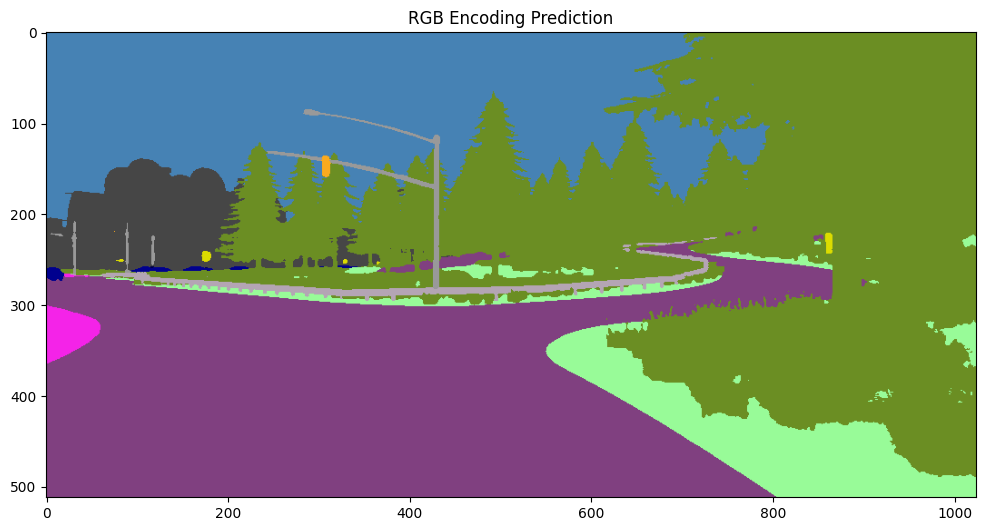

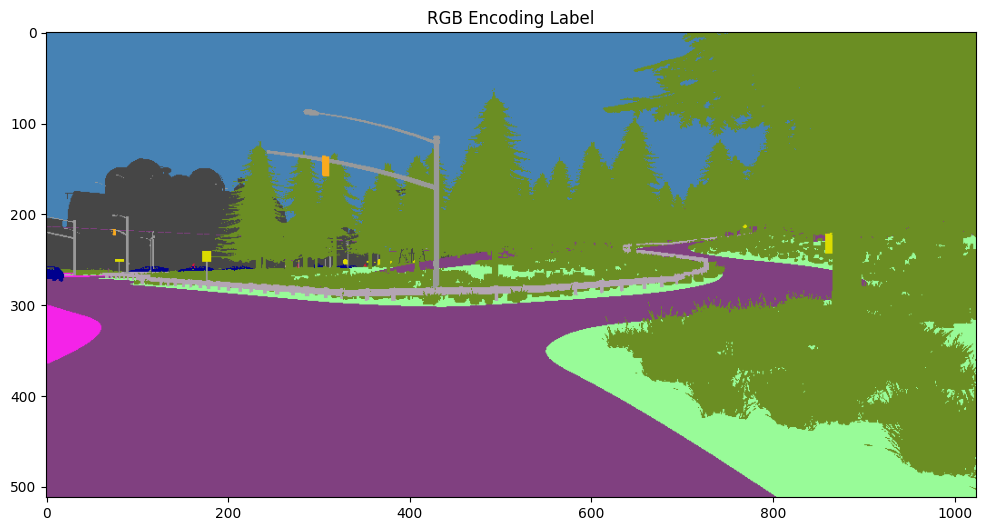

In [35]:
rgb_encoding = segmentation_map_to_rgb_encoding(prediction, rgb_to_class_id)

print("RGB Encoding shape:", rgb_encoding.shape)

plt.figure(figsize=(12, 12))
plt.imshow(rgb_encoding)
plt.title("RGB Encoding Prediction")
plt.show()


rgb_encoding = segmentation_map_to_rgb_encoding(np.squeeze(label), rgb_to_class_id)

plt.figure(figsize=(12, 12))
plt.imshow(rgb_encoding)
plt.title("RGB Encoding Label")
plt.show()